# Modelling and fitting a single line spectrum

In [1]:
# inline plotting for jupyter notebook. Do not put this line in a real python script.
%matplotlib inline

In [2]:
import orb.fit
import pylab as pl
import numpy as np

### Retrieve the observation parameters of a cube of data

Basic observation parameters can be retrieved from any data cube. 
They are useful to simulate a spectrum which corresponds to your data.

In [3]:
# import base class for the manipulation of a SITELLE spectral cube: HDFCube
from orcs.core import HDFCube

In [4]:
# load spectral cube
cube = HDFCube('/home/thomas/M31_SN3.merged.cm1.1.0.hdf5')
print 'step (scan step size in nm): ', cube.params.step
print 'order: ', cube.params.order
print 'resolution: ', cube.params.resolution
print 'theta (incident angle at the center of the frame in degrees): ', cube.params.theta_proj
print 'axis correction coefficient (calibration coefficient of the wavenumber axis which only depends on theta)', cube.params.axis_corr

INFO| Data shape : (2048, 2064, 840)
INFO| Cube is in WAVENUMBER (cm-1)
INFO| Cube is CALIBRATED in wavenumber


step (scan step size in nm):  2943.025792
order:  8
resolution:  4733.11731899
theta (incident angle at the center of the frame in degrees):  15.4447050003
axis correction coefficient (calibration coefficient of the wavenumber axis which only depends on theta) 1.03746502972


### Model a spectrum with one Halpha line

(15200, 15270)

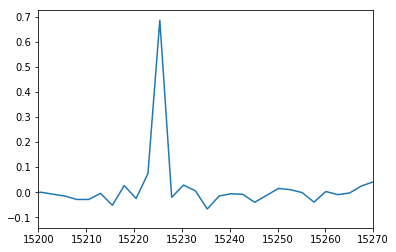

In [5]:
from orb.core import Lines
halpha_cm1 = Lines().get_line_cm1('Halpha')

step = 2943
order = 8
resolution = 5000
theta = 15.5
axis_corr = 1. / np.cos(np.deg2rad(theta))

# model spectrum
velocity = 250
broadening = 15
spectrum = orb.fit.create_cm1_lines_model([halpha_cm1], [1], step, order, resolution, theta, fmodel='sincgauss',
                                           sigma=broadening, vel=velocity)

# add noise
spectrum += np.random.standard_normal(spectrum.shape) * 0.03

spectrum_axis = orb.utils.spectrum.create_cm1_axis(np.size(spectrum), step, order, corr=axis_corr)

pl.plot(spectrum_axis, spectrum)
pl.xlim((15200, 15270))


### Fit the spectrum with a classic Levenberg-Marquardt algorithm

velocity (in km/s):  [239.5(1.2)]
broadening (in km/s):  [9.6(3.8)]
flux (in the unit of the spectrum amplitude / unit of the axis fwhm):  [0.781(50)]


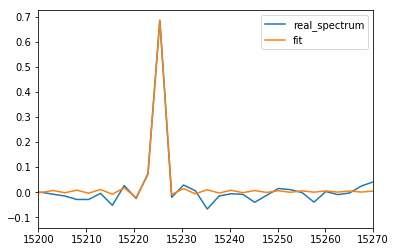

In [7]:
nm_laser = 543.5 # wavelength of the calibration laser, in fact it can be any real positive number (e.g. 1 is ok)
# note: an apodization of 1 means: no apodization (which is the case here)
#
# pos_cov is the velocity of the lines in km/s. It is a covarying parameter,
# because the reference position -i.e. the initial guess- of the lines is set
# 
# sigma_guess is the initial guess on the broadening (in km/s)
fit = orb.fit.fit_lines_in_spectrum(spectrum, [halpha_cm1], step, order, nm_laser, theta, 0, 
                                    wavenumber=True, apodization=1, fmodel='sincgauss',
                                    pos_def=['1'],
                                    pos_cov=velocity, sigma_guess=broadening)
print 'velocity (in km/s): ', fit['velocity_gvar']
print 'broadening (in km/s): ', fit['broadening_gvar']
print 'flux (in the unit of the spectrum amplitude / unit of the axis fwhm): ', fit['flux_gvar']
pl.plot(spectrum_axis, spectrum, label='real_spectrum')
pl.plot(spectrum_axis, fit['fitted_vector'], label='fit')
pl.xlim((15200, 15270))
pl.legend()